# House Property Sales

> Di project ini, saya mencoba menggunakan model ARIMA dan SARIMA untuk melakukan forecasting dengan jangka waktu 1 tahun pada harga properti rumah.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [2]:
sales = pd.read_csv('raw_sales.csv')

In [3]:
sales.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [4]:
sales = sales.drop(['postcode','propertyType','bedrooms'], axis = 1)

In [5]:
sales.head()

,datesold,price
0,2007-02-07 00:00:00,525000
1,2007-02-27 00:00:00,290000
2,2007-03-07 00:00:00,328000
3,2007-03-09 00:00:00,380000
4,2007-03-21 00:00:00,310000


In [6]:
def dt(x): # x --> sales['datesold']
    return pd.to_datetime(x)

sales['datesold'] = sales['datesold'].apply(dt)

In [7]:
df = sales.set_index('datesold')

In [8]:
df.head()

,price
datesold,
2007-02-07,525000
2007-02-27,290000
2007-03-07,328000
2007-03-09,380000
2007-03-21,310000


In [9]:
print('The data Time range from {} to {}'.format(df.index.min(),df.index.max()))

The data Time range from 2007-02-07 00:00:00 to 2019-07-27 00:00:00


In [10]:
y = df['price'].resample('MS').mean()

In [11]:
y.head()

datesold
2007-02-01    407500.000000
2007-03-01    339333.333333
2007-04-01    798000.000000
2007-05-01    339500.000000
2007-06-01    520333.333333
Freq: MS, Name: price, dtype: float64

In [12]:
y.isna().sum()

0

# Exploratory Data Analysis

Text(0.5, 1.0, 'The Trend')

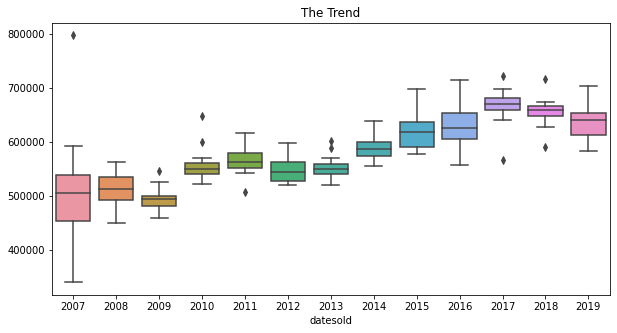

In [13]:
plt.figure(figsize = (10,5))
sns.boxplot(y = y.values, x = y.index.year)
plt.title('The Trend')

Text(0.5, 1.0, 'The Seasonality')

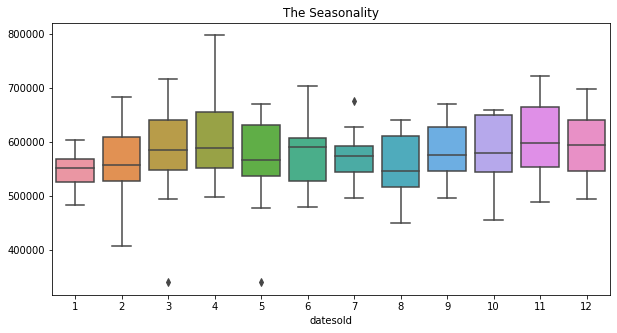

In [14]:
plt.figure(figsize = (10,5))
sns.boxplot(y = y.values, x = y.index.month)
plt.title('The Seasonality')

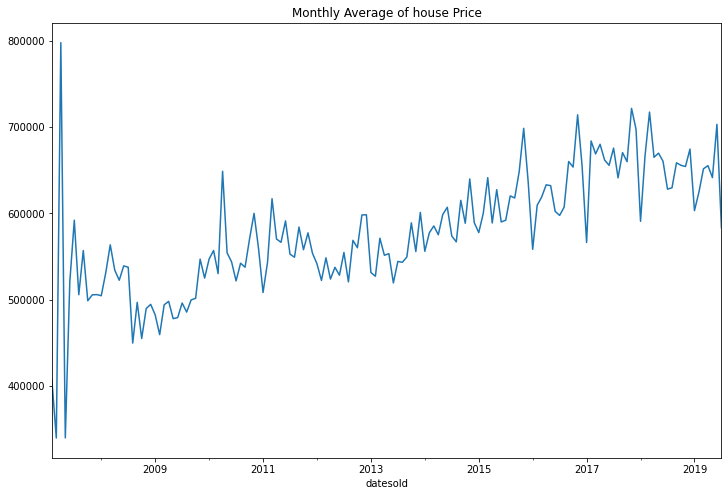

In [15]:
plt.figure(figsize = (12,8))
plt.title('Monthly Average of house Price')
y.plot()

> Dari plot di atas, sebenarnya sudah dapat dilihat bahwa plot ini tidaklah stationary. Namun untuk memastikannya, saya akan melakukan <i>Dickey Fuller test.</i>

## Time series decomposition

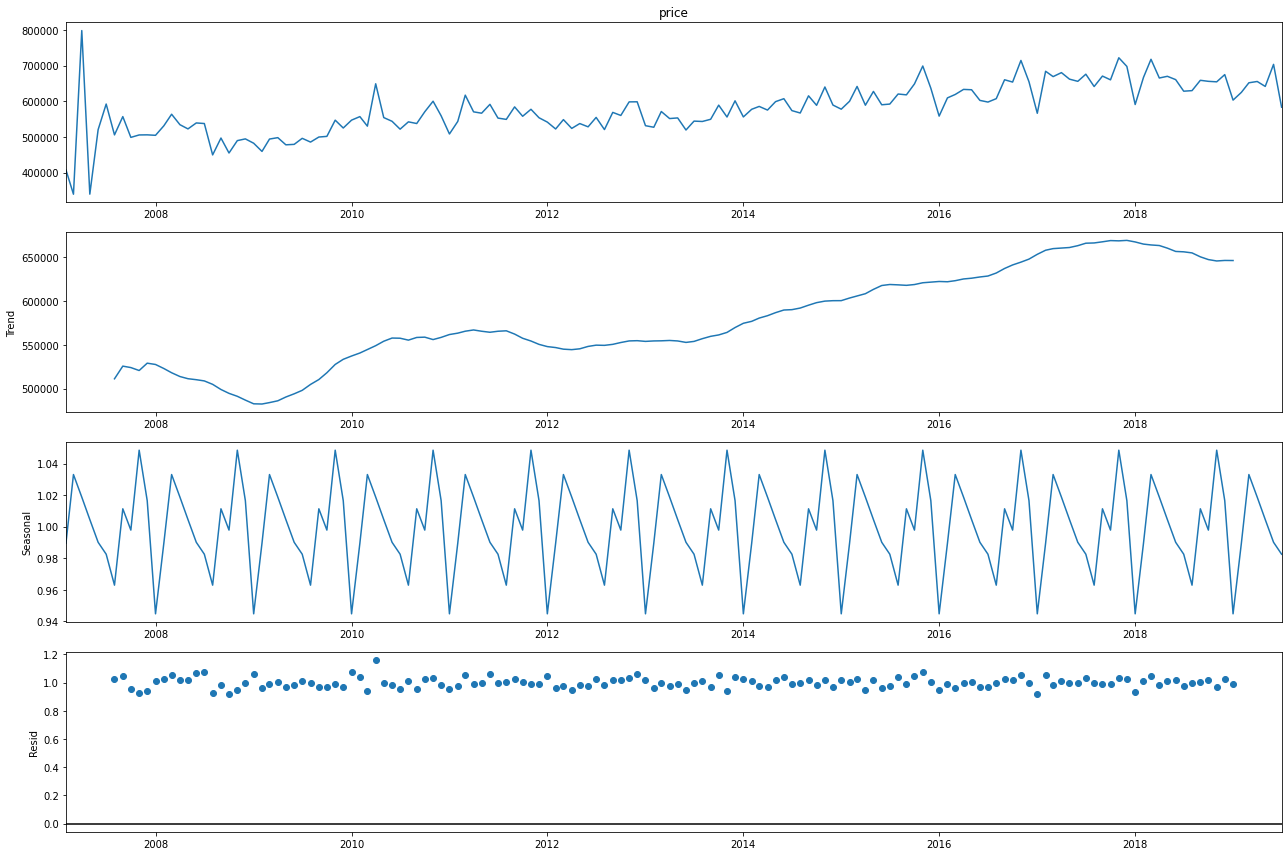

ADF Statistic:-0.6602138026458335
p-value: 0.8567877254659427


In [16]:
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

result = adfuller(y)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

> Terlihat bahwa time-series ini tidaklah stationary.

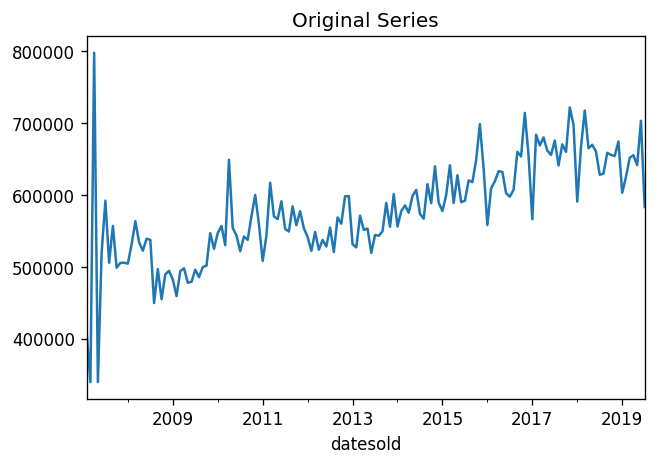

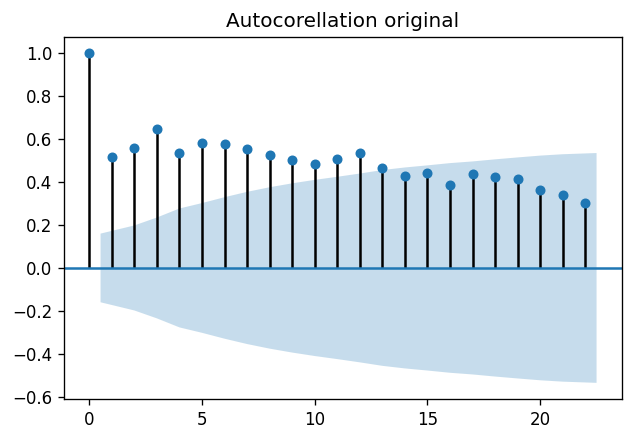

In [17]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

ori = y.plot()
ori.set_title('Original Series')
plot_acf(y, title = 'Autocorellation original')

plt.show()

> Dari plot di atas, terlihat bahwa lag yang besar pun masih memiliki korelasi yang signifikan. Yang mengartikan bahwa time-series ini butuh <i>differencing</i>. 

## Making a time series Stationary

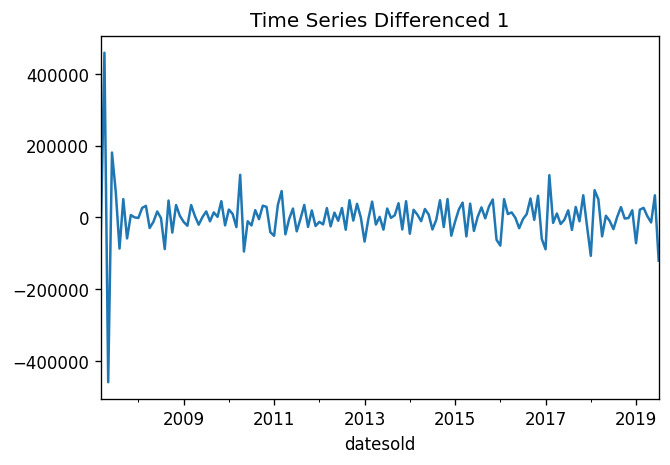

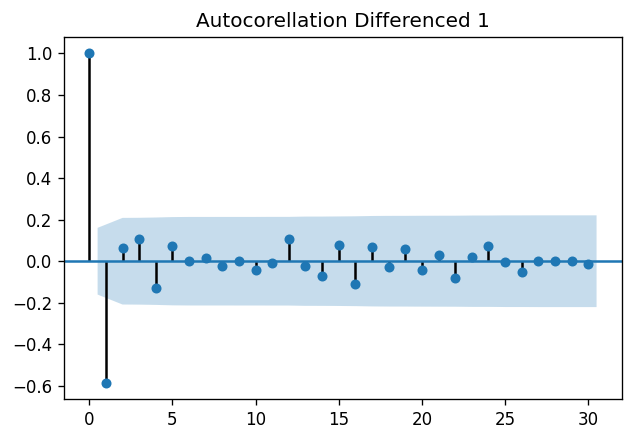

ADF Statistic:-5.3037712186114785
p-value: 5.378016232766266e-06


In [18]:
diff1 = y.diff().dropna().plot()
diff1.set_title('Time Series Differenced 1')
plot_acf(y.diff(1).dropna(),lags =30,  title = 'Autocorellation Differenced 1')

plt.show()

result = adfuller(y.diff().dropna())
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

Sekarang lebih baik

In [19]:
y_difference_1 = y.diff().dropna()

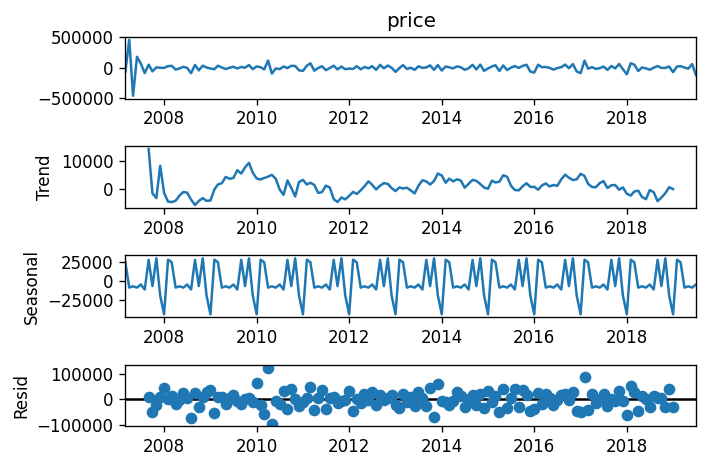

In [20]:
decomposition_difference_1 = sm.tsa.seasonal_decompose(y_difference_1, model='additive') 
fig = decomposition_difference_1.plot()
plt.show()

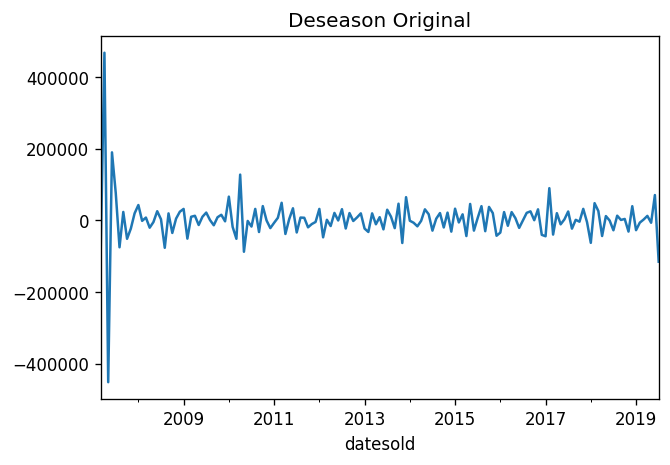

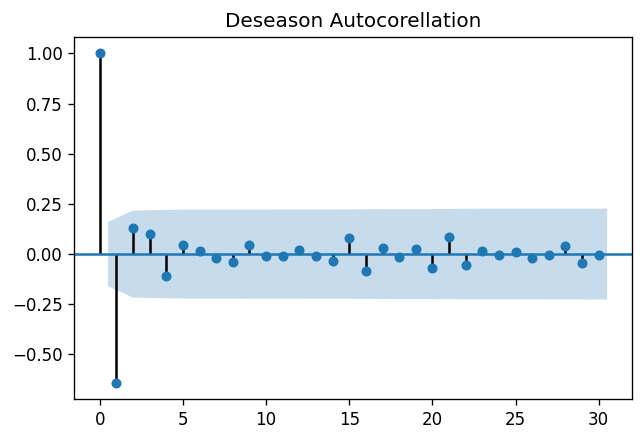

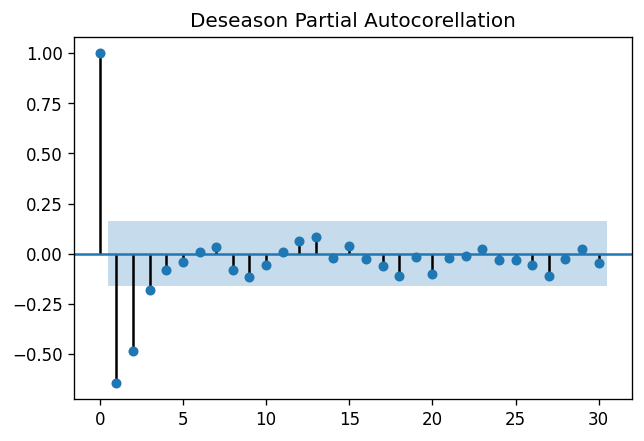

ADF Statistic:-10.666888431770152
p-value: 4.2645906726939863e-19


In [21]:
y_deseason = y_difference_1-decomposition_difference_1.seasonal

ori_deseason = y_deseason.plot()
ori_deseason.set_title('Deseason Original')
plot_acf(y_deseason, lags  = 30, title = 'Deseason Autocorellation')
plot_pacf(y_deseason, lags = 30, title = 'Deseason Partial Autocorellation')

plt.show()

result = adfuller(y_deseason)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

# Train-Test Split

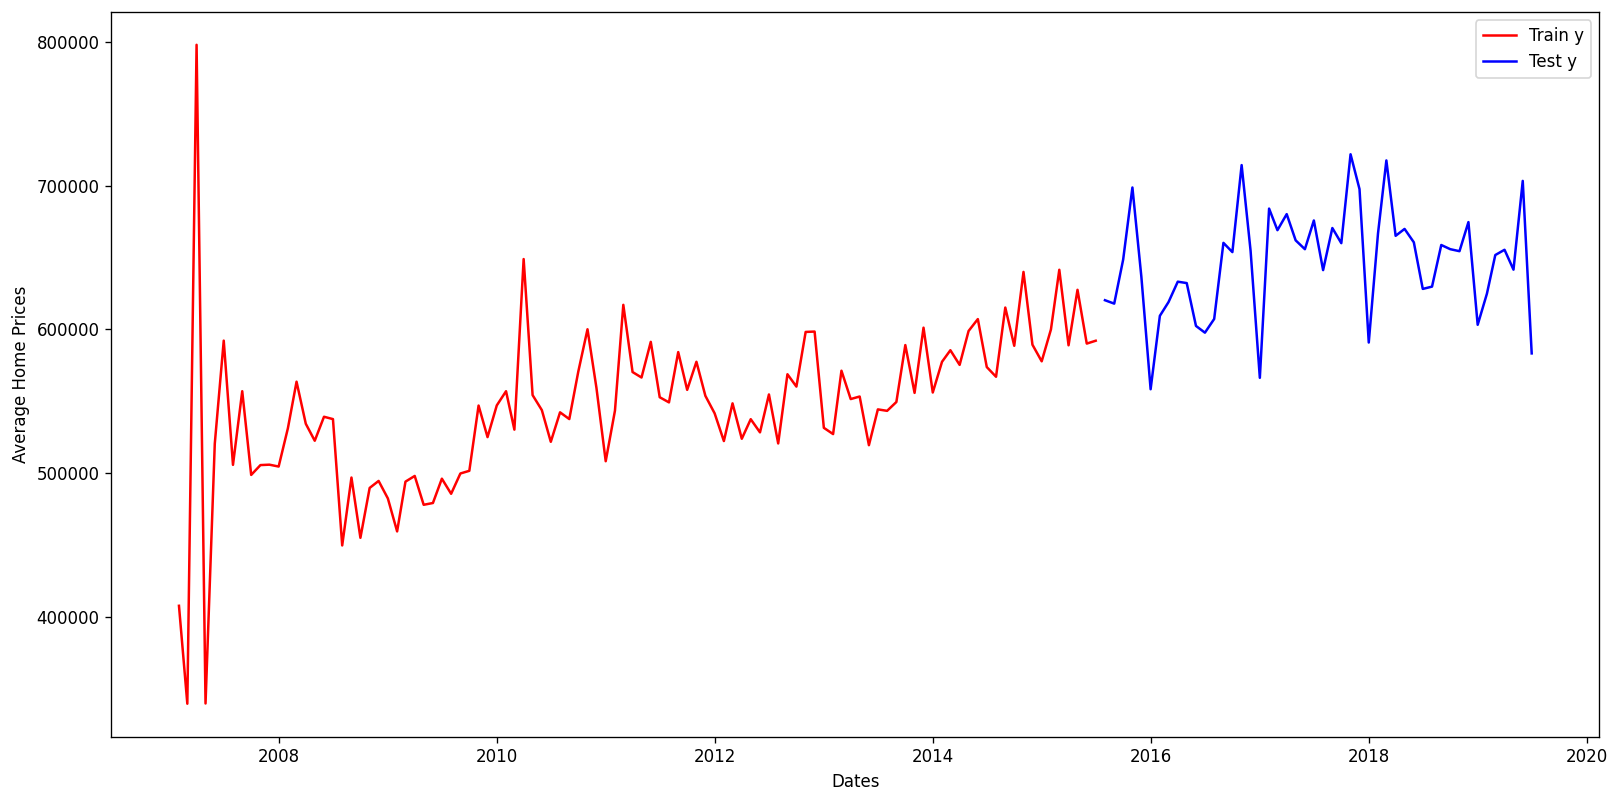

In [22]:
train, test = y[0:int(len(y))-48], y[int(len(y))-48:]

plt.figure(figsize=(16,8))
plt.xlabel('Dates')
plt.ylabel('Average Home Prices')
plt.plot(train, 'r', label='Train y')
plt.plot(test, 'b', label='Test y')
plt.legend()

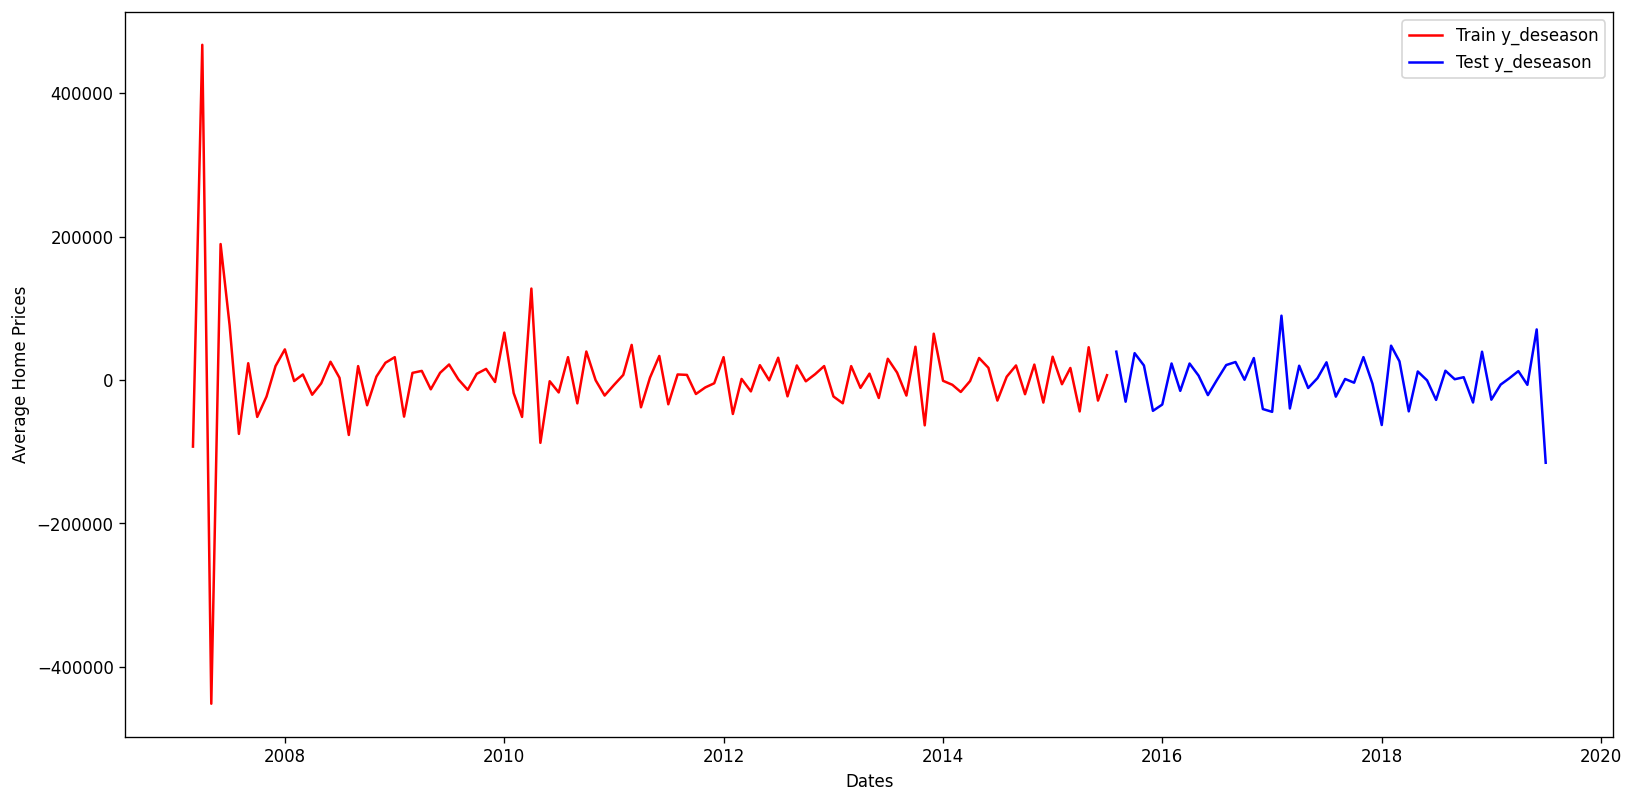

In [23]:
train, test = y_deseason[0:int(len(y_deseason))-48], y_deseason[int(len(y_deseason))-48:]

plt.figure(figsize=(16,8))
plt.xlabel('Dates')
plt.ylabel('Average Home Prices')
plt.plot(train, 'r', label='Train y_deseason')
plt.plot(test, 'b', label='Test y_deseason')
plt.legend()

#  ARIMA Model

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=2538.024, BIC=2548.484, Time=0.529 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=2558.917, BIC=2564.147, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=2501.404, BIC=2509.250, Time=0.046 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=2480.298, BIC=2488.143, Time=0.313 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=2556.979, BIC=2559.595, Time=0.016 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=2493.263, BIC=2503.724, Time=0.176 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=2515.629, BIC=2528.704, Time=0.244 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=2516.108, BIC=2529.183, Time=0.234 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=2515.137, BIC

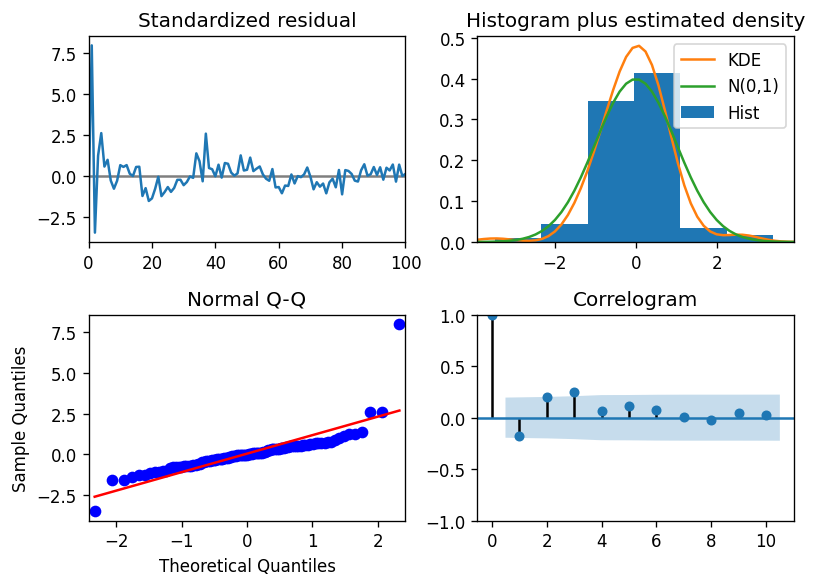

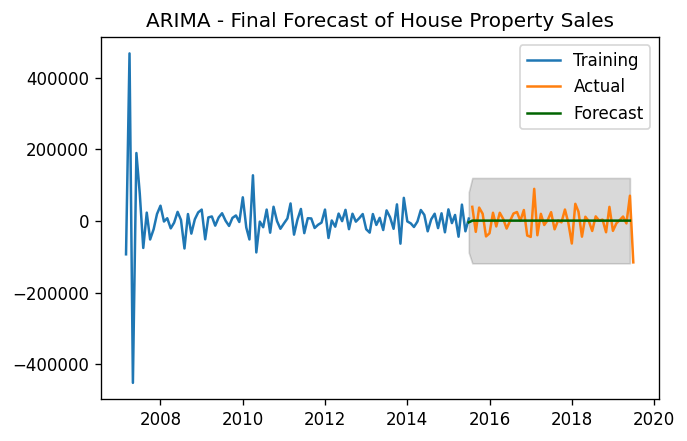

MAPE : 8.00592070281764


In [24]:
train, test = y_deseason[0:int(len(y_deseason))-48], y_deseason[int(len(y_deseason))-48:]

model = pm.auto_arima(train, start_p=1, start_q=1, test='adf', max_p=3, max_q=3,
                      m=1, seasonal=False, start_P=0, 
                      D=0, trace=True, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

fitted, confint = model.predict(n_periods= 48, return_conf_int=True) 
index_of_fc = pd.date_range(train.index[-1], periods = 48, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(train, label ='Training')
plt.plot(test, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of House Property Sales")
plt.show()

print('MAPE : {}'.format(np.mean(np.abs(fitted - test)/np.abs(test))))

Pada hasil di atas, ARIMA memiliki MAPE yang tinggi dan forecastnya hanya memberikan garis lurus. 

# SARIMA Model

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=2315.332, BIC=2325.287, Time=0.496 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=2278.462, BIC=2283.439, Time=0.051 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=2207.377, BIC=2217.331, Time=0.671 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=2214.560, BIC=2224.515, Time=0.874 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=2277.345, BIC=2279.833, Time=0.041 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=2234.692, BIC=2242.158, Time=0.190 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; AIC=2196.447, BIC=2208.891, Time=2.481 seconds
Fit ARIMA(1,1,0)x(2,1,1,12) [intercept=True]; AIC=2197.704, BIC=2212.636, Time=2.990 seconds
Fit ARIMA(1,1,0)x(1,1,1,12) [intercept=True]; AIC=2198.378, BIC=2210.822, Time=1.275 seconds
Fit ARIMA(0,1,0)x(2,1,0,12) [intercept=True]; AIC=2235.091, BIC=2245.046, Time=0.962 seconds
Fit ARIMA(2,1,0)x(2,1,0,12

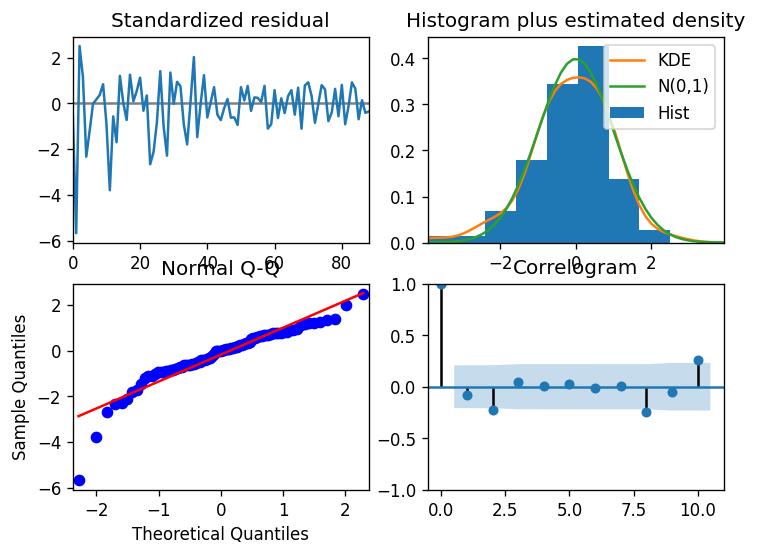

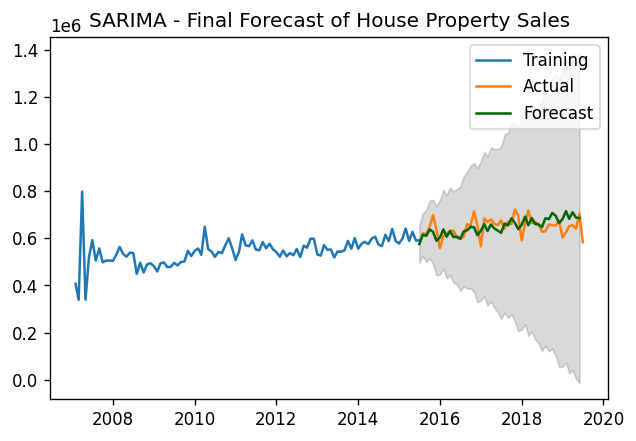

MAPE : 0.0447525048993006


In [25]:
train, test = y[0:int(len(y))-48], y[int(len(y))-48:]

model = pm.auto_arima(train, start_p=1, start_q=1, test='adf',   
                      max_p=5, max_q=5, m=12,             
                      seasonal=True, start_P=0, 
                      start_Q = 0, D=1,           
                      trace=True, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.show()

fitted, confint = model.predict(n_periods= 48, return_conf_int=True) 
index_of_fc = pd.date_range(train.index[-1], periods = 48, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(train, label ='Training')
plt.plot(test, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of House Property Sales")
plt.show()

print('MAPE : {}'.format(np.mean(np.abs(fitted - test)/np.abs(test))))

* Residual terlihat mengikuti distribusi normal dan tidak memiliki korelasi yang signifikan. Namun seharusnya bisa lebih baik lagi, melihat model di atas masih sedikit bias.
* MAPE hanya sekitar 0.044 yang menandakan akurasi yang tinggi. itu kenapa SARIMA akan menjadi model yang tepat untuk dataset ini.

# Fitting and Prediction

> Forecasting for 1 year prediction

In [26]:
model.fit(train)

ARIMA(order=(2, 1, 0), seasonal_order=(2, 1, 0, 12), suppress_warnings=True)

In [27]:
test.tail(1)

datesold
2019-07-01    583192.056
Freq: MS, Name: price, dtype: float64

In [28]:
year = pd.date_range('2019-08-01', periods = 12, freq = 'MS')

forecast = model.predict(n_periods = 12)

df_fc = pd.DataFrame({'forecast' : forecast}, index = year)
df_fc

,forecast
2019-08-01,575603.279322
2019-09-01,615227.955324
2019-10-01,610332.434075
2019-11-01,637666.296854
2019-12-01,627325.348819
2020-01-01,589792.019377
2020-02-01,603320.490558
2020-03-01,638076.334806
2020-04-01,607053.313225
2020-05-01,630246.033024


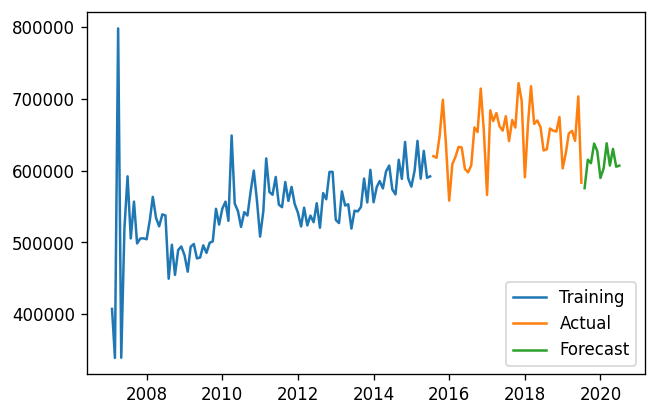

In [29]:
plt.plot(train, label ='Training')
plt.plot(test, label = 'Actual')
plt.plot(df_fc['forecast'], label = 'Forecast')
plt.legend()

# Conclusion

SARIMA model yang lebih baik dari ARIMA dalam menangani hal ini. Itu kenapa faktor musim tidak dapat dihiraukan pada penjualan properti rumah.